In [1]:
#importing necessary lib.
import pandas as pd 

In [2]:
#load the data 
qvi_data=pd.read_csv('QVI_data.csv')

In [3]:
#covert 'DATE' column to datetime
qvi_data["DATE"] = pd.to_datetime(qvi_data["DATE"])

In [4]:
# Extract month for grouping
qvi_data["MONTH"] = qvi_data["DATE"].dt.to_period("M")

In [5]:
# Group by STORE_NBR and MONTH to compute key metrics
monthly_metrics = qvi_data.groupby(["STORE_NBR", "MONTH"]).agg(
    total_sales_revenue=("TOT_SALES", "sum"),
    total_customers=("LYLTY_CARD_NBR", pd.Series.nunique),
    total_transactions=("TXN_ID", pd.Series.nunique)
).reset_index()

In [6]:
# Add average transactions per customer
monthly_metrics["avg_transactions_per_customer"] = (
    monthly_metrics["total_transactions"] / monthly_metrics["total_customers"]
)


In [7]:
# Preview
monthly_metrics.head()

,STORE_NBR,MONTH,total_sales_revenue,total_customers,total_transactions,avg_transactions_per_customer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739



## Phase 1: Control Store Selection

### Step 1: Data Loading & Exploration
- Loaded the `QVI_data.csv` dataset with 264,834 transaction records.
- Key columns identified:
  - `DATE`: Transaction date
  - `STORE_NBR`: Store number
  - `TXN_ID`: Transaction ID
  - `LYLTY_CARD_NBR`: Customer ID
  - `TOT_SALES`: Total sales value
  - `PROD_QTY`: Quantity purchased

### Step 2: Data Preprocessing
- Converted the `DATE` column to datetime format.
- Created a `MONTH` column for month-wise grouping.

### Step 3: Monthly Metrics Calculation
- Calculated the following monthly metrics per store:
  - **Total Sales Revenue**
  - **Total Number of Unique Customers**
  - **Total Transactions**
  - **Average Transactions per Customer** (calculated as: total transactions / unique customers)

---

## Phase 2: Control Store Identification (Next Step)
We'll now:
1. Create a **function** to find the most similar control store for each trial store.
2. Use similarity metrics such as:
   - **Pearson correlation** (for trend similarity)
   - **Magnitude distance score** for profile closeness
3. **Visualize** comparison trends (sales, customers, transactions) to validate control store choices.


In [8]:
from scipy.stats import pearsonr
import numpy as np

def calculate_similarity(trial_store, metrics_df, pre_trial_months):
    """
    Calculates similarity scores between a trial store and all other stores.

    Parameters:
        trial_store (int): The store number of the trial store.
        metrics_df (DataFrame): Monthly metrics with columns [STORE_NBR, MONTH, total_sales_revenue, total_customers, avg_transactions_per_customer].
        pre_trial_months (list of str or Period): Months before the trial for comparison.

    Returns:
        DataFrame: Similarity scores of all stores to the trial store.
    """
    trial_data = metrics_df[(metrics_df["STORE_NBR"] == trial_store) & (metrics_df["MONTH"].isin(pre_trial_months))]

    similarities = []

    for store in metrics_df["STORE_NBR"].unique():
        if store == trial_store:
            continue

        store_data = metrics_df[(metrics_df["STORE_NBR"] == store) & (metrics_df["MONTH"].isin(pre_trial_months))]

        if len(store_data) != len(trial_data):
            continue  # Skip if months mismatch

        # Pearson correlations
        corr_sales, _ = pearsonr(trial_data["total_sales_revenue"], store_data["total_sales_revenue"])
        corr_customers, _ = pearsonr(trial_data["total_customers"], store_data["total_customers"])

        # Magnitude distance score (closer to 1 is better)
        def magnitude_score(trial_vals, store_vals):
            distance = np.sum(np.abs(trial_vals - store_vals))
            return 1 - (distance - distance.min()) / (distance.max() - distance.min() + 1e-9)

        mag_sales = magnitude_score(trial_data["total_sales_revenue"].values, store_data["total_sales_revenue"].values)
        mag_customers = magnitude_score(trial_data["total_customers"].values, store_data["total_customers"].values)

        overall_score = (corr_sales + corr_customers + mag_sales + mag_customers) / 4

        similarities.append({
            "store": store,
            "corr_sales": corr_sales,
            "corr_customers": corr_customers,
            "mag_sales": mag_sales,
            "mag_customers": mag_customers,
            "overall_score": overall_score
        })

    return pd.DataFrame(similarities).sort_values(by="overall_score", ascending=False)


## Function: `calculate_similarity`

### Purpose
This function is used to identify the **most similar control store** for a given trial store based on pre-trial monthly performance metrics. Selecting a comparable control store is essential for evaluating the effect of a trial (e.g., a marketing experiment) using a quasi-experimental design.

---

### Parameters
- `trial_store` *(int)*: The store number of the trial store.
- `metrics_df` *(DataFrame)*: Contains monthly aggregated metrics per store, including:
  - `total_sales_revenue`
  - `total_customers`
  - `avg_transactions_per_customer`
- `pre_trial_months` *(list of Periods or strings)*: The list of months before the trial, used for calculating similarity.

---

### How Similarity is Calculated

The function evaluates similarity using two main statistical approaches:

#### 1. Pearson Correlation
- Measures the **trend similarity** over time between the trial and each other store.
- Applied to:
  - `total_sales_revenue`
  - `total_customers`
- Captures whether the two stores move similarly in time (e.g., both peak in the same months).

#### 2. Magnitude Distance Score
- Measures **how close the actual values** of metrics are, regardless of trends.
- Computes absolute differences between the trial store and each candidate control store.
- Applied to:
  - `total_sales_revenue`
  - `total_customers`
- The final score is normalized and inverted (so that higher is better).

---

### Final Similarity Score
An **overall score** is calculated for each candidate store as the average of:
- Pearson correlation on sales
- Pearson correlation on customers
- Magnitude score on sales
- Magnitude score on customers

Stores are then ranked by this overall score in descending order to find the most suitable control store.

---

### Returns
A **DataFrame** containing:
- Store number
- Individual similarity scores (`corr_sales`, `corr_customers`, `mag_sales`, `mag_customers`)
- Final `overall_score`
Sorted by `overall_score` in descending order.


In [14]:
pre_trial_months = [pd.Period('2018-07', freq='M'), pd.Period('2018-08', freq='M'), pd.Period('2018-09', freq='M')]
trial_stores = [77, 86, 88]


### Pre-Trial Setup

- **Pre-Trial Months:** Selected as July 2018 to September 2018 to establish a performance baseline before any trial intervention.
- **Trial Stores:** The trial is conducted on the following stores:
  - Store 77
  - Store 86
  - Store 88


In [23]:
control_store_map = {}

for trial_store in trial_stores:
    sim_df = calculate_similarity(trial_store, monthly_metrics, pre_trial_months)
    best_control = sim_df.iloc[0]['store']  # store with highest overall similarity score
    control_store_map[trial_store] = best_control

control_store_map


{77: 71.0, 86: 54.0, 88: 19.0}

### Control Store Selection

For each trial store, we identified the most similar control store using the `calculate_similarity` function.  
This function compares pre-trial performance metrics and assigns similarity scores.  
The store with the highest overall similarity score is selected as the control store.

The resulting `control_store_map` dictionary stores the mapping between each trial store and its corresponding control store.


In [30]:
pre_trial_months = [pd.Period(m, freq='M') for m in ['2018-07', '2018-08', '2018-09']]
trial_months = [pd.Period(m, freq='M') for m in ['2019-04', '2019-06', '2019-05']]


### Defining Time Periods

We define two key timeframes for the analysis:

- `pre_trial_months`: The three months prior to the trial period, used to evaluate historical similarity between stores.
- `trial_months`: The months during which the trial was conducted, used to assess the impact of the trial.

These periods are represented using `pandas.Period` with monthly frequency (`'M'`).


In [31]:
def compare_trial_control(trial_store, control_store, metrics_df, trial_months):
    trial_data = metrics_df[(metrics_df["STORE_NBR"] == trial_store) & (metrics_df["MONTH"].isin(trial_months))]
    control_data = metrics_df[(metrics_df["STORE_NBR"] == control_store) & (metrics_df["MONTH"].isin(trial_months))]

    if trial_data.empty or control_data.empty:
        print(f"Warning: No data found for trial store {trial_store} or control store {control_store} in trial months.")
        return pd.DataFrame()  # return empty to avoid error

    # Make sure indices are MONTH for proper alignment
    trial_data = trial_data.set_index("MONTH")
    control_data = control_data.set_index("MONTH")

    # Align indexes and join to avoid missing months
    combined_index = trial_months
    trial_data = trial_data.reindex(combined_index)
    control_data = control_data.reindex(combined_index)

    comparison_df = pd.DataFrame({
        "MONTH": combined_index,
        "trial_total_sales": trial_data["total_sales_revenue"].values,
        "control_total_sales": control_data["total_sales_revenue"].values,
        "trial_total_customers": trial_data["total_customers"].values,
        "control_total_customers": control_data["total_customers"].values,
        "trial_avg_transactions_per_customer": trial_data["avg_transactions_per_customer"].values,
        "control_avg_transactions_per_customer": control_data["avg_transactions_per_customer"].values,
    })

    return comparison_df.reset_index(drop=True)


### Function: `compare_trial_control`

This function compares the performance of a trial store with its matched control store during the trial period.

#### Parameters:
- `trial_store`: Store number for the trial store.
- `control_store`: Store number for the matched control store.
- `metrics_df`: DataFrame containing monthly metrics (`total_sales_revenue`, `total_customers`, `avg_transactions_per_customer`).
- `trial_months`: List of months representing the trial period.

#### Process:
1. Filters the data for the specified `trial_store` and `control_store` during the `trial_months`.
2. Handles any missing data by checking for empty dataframes and returning an empty DataFrame if no data is available.
3. Aligns the data based on the `MONTH` index to ensure accurate comparison.
4. Constructs a new DataFrame with side-by-side metrics for trial vs control store.

#### Output:
Returns a DataFrame with the following columns:
- `MONTH`
- `trial_total_sales` vs `control_total_sales`
- `trial_total_customers` vs `control_total_customers`
- `trial_avg_transactions_per_customer` vs `control_avg_transactions_per_customer`

This enables direct performance comparison for further statistical analysis or visualization.


In [32]:
for trial_store, control_store in control_store_map.items():
    print(f"\nComparing Trial Store {trial_store} with Control Store {control_store}")
    comp_df = compare_trial_control(trial_store, control_store, monthly_metrics, trial_months)
    if comp_df.empty:
        print("Comparison skipped due to missing data.")
    else:
        print(comp_df)



Comparing Trial Store 77 with Control Store 71.0
     MONTH  trial_total_sales  control_total_sales  trial_total_customers  \
0  2019-04              263.5                980.0                     47   
1  2019-06              264.7                922.8                     41   
2  2019-05              299.3                900.5                     55   

   control_total_customers  trial_avg_transactions_per_customer  \
0                      115                             1.021277   
1                      104                             1.024390   
2                      111                             1.018182   

   control_avg_transactions_per_customer  
0                               1.226087  
1                               1.288462  
2                               1.234234  

Comparing Trial Store 86 with Control Store 54.0
     MONTH  trial_total_sales  control_total_sales  trial_total_customers  \
0  2019-04              848.2               517.40                    105

### Comparing Trial Stores with Matched Control Stores

This loop iterates through each trial-control store pair from the `control_store_map` and compares their performance during the trial period.

#### Process:
- For each trial store, retrieves its corresponding control store.
- Calls the `compare_trial_control` function to generate a comparison DataFrame.
- If no data is found for the trial or control store during the specified months, a warning is printed and the comparison is skipped.
- Otherwise, the comparison DataFrame is printed, showing side-by-side metrics for each month in the trial period.

This step ensures that we evaluate the effectiveness of the trial by benchmarking it against a similar non-trial store.


In [33]:
def summarize_performance(comp_df):
    comp_df = comp_df.sort_values("MONTH")
    comp_df["sales_lift_pct"] = (comp_df["trial_total_sales"] - comp_df["control_total_sales"]) / comp_df["control_total_sales"] * 100
    comp_df["customer_lift_pct"] = (comp_df["trial_total_customers"] - comp_df["control_total_customers"]) / comp_df["control_total_customers"] * 100
    comp_df["avg_txn_per_cust_lift_pct"] = (comp_df["trial_avg_transactions_per_customer"] - comp_df["control_avg_transactions_per_customer"]) / comp_df["control_avg_transactions_per_customer"] * 100
    
    return comp_df[["MONTH", "sales_lift_pct", "customer_lift_pct", "avg_txn_per_cust_lift_pct"]]

for trial_store, control_store in control_store_map.items():
    print(f"\nPerformance Summary: Trial Store {trial_store} vs Control Store {control_store}")
    comp_df = compare_trial_control(trial_store, control_store, monthly_metrics, trial_months)
    if comp_df is not None:
        summary_df = summarize_performance(comp_df)
        print(summary_df)



Performance Summary: Trial Store 77 vs Control Store 71.0
     MONTH  sales_lift_pct  customer_lift_pct  avg_txn_per_cust_lift_pct
0  2019-04      -73.112245         -59.130435                 -16.704391
2  2019-05      -66.762909         -50.450450                 -17.504977
1  2019-06      -71.315561         -60.576923                 -20.495086

Performance Summary: Trial Store 86 vs Control Store 54.0
     MONTH  sales_lift_pct  customer_lift_pct  avg_txn_per_cust_lift_pct
0  2019-04       63.935060          94.444444                   9.830508
2  2019-05      162.679073         160.000000                  14.490161
1  2019-06      115.037208         127.906977                  12.555457

Performance Summary: Trial Store 88 vs Control Store 19.0
     MONTH  sales_lift_pct  customer_lift_pct  avg_txn_per_cust_lift_pct
0  2019-04      101.540185          58.024691                  15.186096
2  2019-05       54.932496          37.634409                   3.602431
1  2019-06       99.

### Performance Summary: Trial vs Control Stores

This section calculates and summarizes the percentage lift in key performance metrics during the trial period, comparing each trial store against its matched control store.

#### Steps:
- For each trial-control store pair:
  - Retrieve the monthly comparison data using `compare_trial_control`.
  - Calculate the percentage lift in:
    - **Sales Revenue** (`sales_lift_pct`): How much sales increased or decreased in the trial store relative to the control.
    - **Customer Count** (`customer_lift_pct`): Change in number of customers visiting the store.
    - **Average Transactions per Customer** (`avg_txn_per_cust_lift_pct`): Change in customer buying frequency or basket size.
- Sort results by month to observe trends over time.
- Print the summarized lift metrics for each month of the trial.

This analysis highlights the drivers behind any observed sales changes, helping to isolate effects due to customer traffic or transaction behavior.


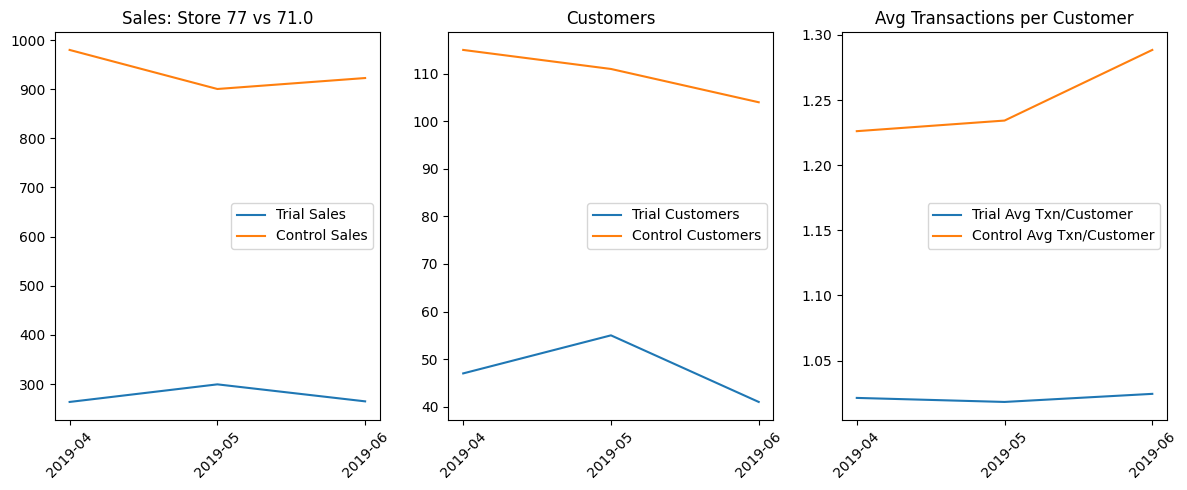

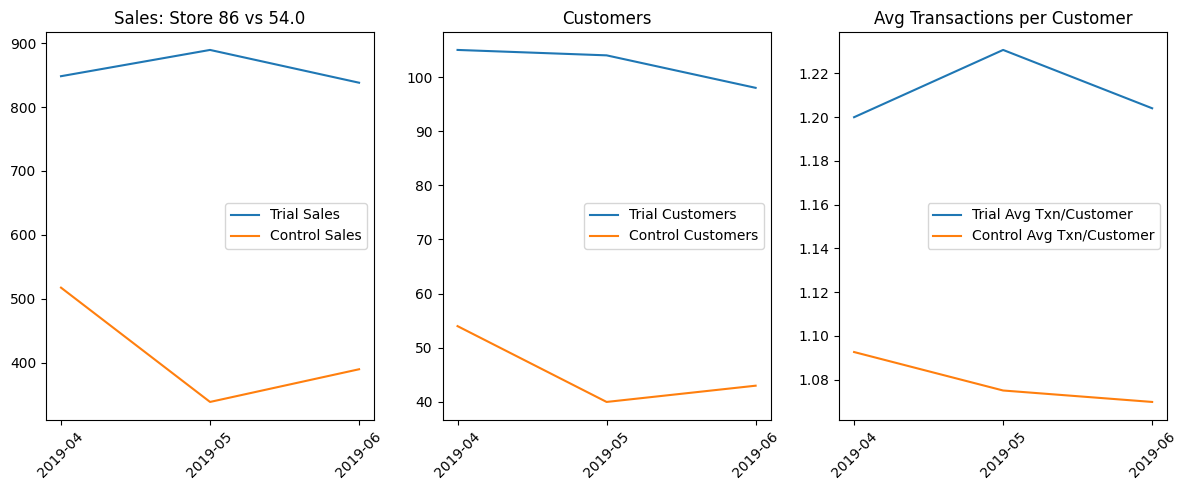

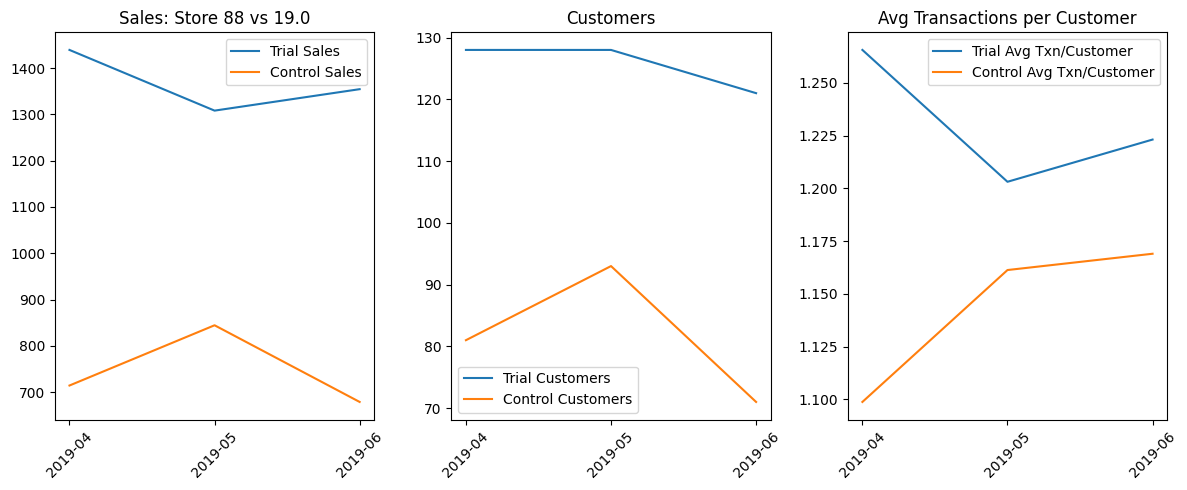

In [34]:
import matplotlib.pyplot as plt

def plot_trial_vs_control(comp_df, trial_store, control_store):
    comp_df = comp_df.sort_values("MONTH")
    months = comp_df["MONTH"].astype(str)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1,3,1)
    plt.plot(months, comp_df["trial_total_sales"], label="Trial Sales")
    plt.plot(months, comp_df["control_total_sales"], label="Control Sales")
    plt.title(f"Sales: Store {trial_store} vs {control_store}")
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(months, comp_df["trial_total_customers"], label="Trial Customers")
    plt.plot(months, comp_df["control_total_customers"], label="Control Customers")
    plt.title("Customers")
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(months, comp_df["trial_avg_transactions_per_customer"], label="Trial Avg Txn/Customer")
    plt.plot(months, comp_df["control_avg_transactions_per_customer"], label="Control Avg Txn/Customer")
    plt.title("Avg Transactions per Customer")
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

for trial_store, control_store in control_store_map.items():
    comp_df = compare_trial_control(trial_store, control_store, monthly_metrics, trial_months)
    if comp_df is not None:
        plot_trial_vs_control(comp_df, trial_store, control_store)


### Visualization of Trial vs Control Store Performance

This section provides visual comparisons between each trial store and its matched control store over the trial months.

#### Description:
- For each trial-control pair:
  - The `compare_trial_control` function fetches aligned monthly metrics.
  - The `plot_trial_vs_control` function generates a 3-panel plot showing:
    - **Total Sales Revenue** comparison
    - **Total Number of Customers** comparison
    - **Average Transactions per Customer** comparison
- Each subplot displays the metric trends side-by-side for the trial and control stores.
- X-axis shows trial months, rotated for readability.

#### Purpose:
- Visual inspection helps to identify patterns, trends, or anomalies.
- Complements statistical tests by showing the magnitude and timing of differences.
- Aids in communicating findings effectively to stakeholders.


In [35]:
from scipy.stats import ttest_rel

def perform_stat_test(comp_df):
    t_sales, p_sales = ttest_rel(comp_df["trial_total_sales"], comp_df["control_total_sales"])
    t_cust, p_cust = ttest_rel(comp_df["trial_total_customers"], comp_df["control_total_customers"])
    t_txn, p_txn = ttest_rel(comp_df["trial_avg_transactions_per_customer"], comp_df["control_avg_transactions_per_customer"])
    
    return {
        "sales_p_value": p_sales,
        "customers_p_value": p_cust,
        "avg_txn_per_customer_p_value": p_txn
    }

for trial_store, control_store in control_store_map.items():
    comp_df = compare_trial_control(trial_store, control_store, monthly_metrics, trial_months)
    if comp_df is not None:
        stats = perform_stat_test(comp_df)
        print(f"\nStatistical Test p-values for Trial Store {trial_store}:")
        print(stats)



Statistical Test p-values for Trial Store 77:
{'sales_p_value': 0.0025444760862866757, 'customers_p_value': 0.0031025478605471914, 'avg_txn_per_customer_p_value': 0.0062755540660712865}

Statistical Test p-values for Trial Store 86:
{'sales_p_value': 0.01993612239899037, 'customers_p_value': 0.004570549190907101, 'avg_txn_per_customer_p_value': 0.010966250785250237}

Statistical Test p-values for Trial Store 88:
{'sales_p_value': 0.016229068836594307, 'customers_p_value': 0.010673749090766663, 'avg_txn_per_customer_p_value': 0.1585840251057154}


### Statistical Testing of Trial vs Control Store Performance

This section conducts paired t-tests to determine if the differences observed between trial and control stores during the trial period are statistically significant.

#### Methodology:
- For each trial-control store pair:
  - Use `compare_trial_control` to get aligned monthly metrics.
  - Perform **paired t-tests** comparing:
    - Total sales revenue
    - Total number of customers
    - Average transactions per customer
- The paired t-test accounts for the matched months in the trial period, testing whether the trial store’s performance significantly differs from its control store.
- p-values from the tests are reported:
  - A low p-value (typically < 0.05) indicates a statistically significant difference.
  - A high p-value suggests no significant difference.

#### Purpose:
- To validate whether observed performance lifts or declines are statistically meaningful or likely due to random variation.
- To support data-driven conclusions about the trial’s impact.
